In [137]:
%load_ext autoreload
%autoreload 2

from fastai.text.all import *
from fastai.vision.all import *
import pandas as pd
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [77]:
OUT_DIM=12
INPUT_DIM=128
BS= 16

In [4]:
train = pd.read_csv("./data/train_fusion.csv")
val = pd.read_csv("./data/val_fusion.csv")
test_data = pd.read_csv("./data/test_fusion.csv")

In [5]:
train["document_type"] = train.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
val["document_type"] = val.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                     axis=1)
test_data["document_type"] = test_data.apply(lambda x: "B-" + x["document_type"] if x["pages"] == 1 else "I-" + x["document_type"],
                                   axis=1)

In [6]:
def get_sequences(data):
    xs = []
    ys = []
    for k, v in data.groupby("process_id").groups.items():
        xs.append(data.iloc[v]["activation_path"].tolist())
        ys.append(data.iloc[v]["document_type"].tolist())
    return xs, ys

In [7]:
X_train, y_train = get_sequences(train)
X_valid, y_valid = get_sequences(val)
X_test, y_test = get_sequences(test_data)

In [8]:
data = pd.concat([pd.DataFrame({"acts":X_train, "labels":y_train, "is_valid": False}),
                 pd.DataFrame({"acts":X_valid, "labels":y_valid, "is_valid": True})])

In [9]:
class GetFusionActs(Transform):
    def encodes(self, x):    
        acts = []
        for act in x["acts"]:
            acts.append(torch.load(act.replace("text", "fusion") + ".pt").unsqueeze(0)) 
        return torch.cat(acts)

In [10]:
class GetLabels(Transform):
    def setup(self, items, train_setup):
        if train_setup:
            self.cat = Categorize()
            self.cat.setup([x for sublist in items.items["labels"].tolist() for x in sublist])
        
    def encodes(self, x):
        labels = []
        for label in x["labels"]:
            labels.append(self.cat(label).unsqueeze(0).unsqueeze(0))
        return torch.cat(labels)

In [11]:
class My_Pad_Input(ItemTransform):
    def encodes(self,samples, pad_fields=0, pad_first=False, backwards=False):
        "Function that collect `samples` and adds padding"
        pad_fields = L(pad_fields)
        max_len_l = pad_fields.map(lambda f: max([len(s[f]) for s in samples]))
        if backwards: pad_first = not pad_first
        def _f(field_idx, x):
            pad_value=0
            if field_idx not in pad_fields: return x
            if field_idx==1:
                pad_value=OUT_DIM
            idx = pad_fields.items.index(field_idx) #TODO: remove items if L.index is fixed
            sl = slice(-len(x), sys.maxsize) if pad_first else slice(0, len(x))
            pad =  x.new_zeros((max_len_l[idx]-x.shape[0], *x.shape[1:]))+pad_value
            x1 = torch.cat([pad, x] if pad_first else [x, pad])
            if backwards: x1 = x1.flip(0)
            return retain_type(x1, x)
        return [tuple(map(lambda idxx: _f(*idxx), enumerate(s))) for s in samples]
my_pad_input=My_Pad_Input()

In [ ]:
tfms = [[GetFusionActs()], [GetLabels()]]
splits = ColSplitter()(data)
dsets = Datasets(data, tfms, splits=splits)
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=partial(my_pad_input, pad_fields=[0,1]), bs=BS)

In [ ]:
dls.one_batch()

In [14]:
torch.save(dls, "./data/dls_sequence.pth")

In [41]:
dls = torch.load("./data/dls_sequence.pth")

In [175]:
class SequenceModel(Module):
    def __init__(self, hidden_dim=128, out_dim=OUT_DIM):
        self.lstm = torch.nn.LSTM(input_size=INPUT_DIM, hidden_size=hidden_dim,
                                  batch_first=True, bidirectional=True).cuda()
        self.bn = nn.BatchNorm1d(hidden_dim*2, momentum=0.01).cuda()
        self.drop = nn.Dropout().cuda()
        self.lin = nn.Linear(hidden_dim*2, out_dim).cuda()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out_norm = self.bn(out)
        out_drop = self.drop(out_norm)
        out_drop = out_drop.permute(0, 2, 1)
        return self.lin(out_drop)

In [176]:
model = SequenceModel()

In [177]:
def loss_func(out, targ):
    return CrossEntropyLossFlat(ignore_index=OUT_DIM)(out, targ.long())

In [178]:
def _accumulate(self, learn):
    pred = learn.pred
    targ = learn.y
    pred,targ = to_detach(pred),to_detach(targ)
    pred =np.argmax(pred, axis=-1)
    pred, targ = flatten_check(pred, targ)
    pad_idxs = [i for i,x in enumerate(targ) if x != tensor([12])]
    pred = pred[pad_idxs]
    targ = targ[pad_idxs]
    pred = torch.remainder(pred, 6)
    targ = torch.remainder(targ, 6)
    self.preds.append(pred)
    self.targs.append(targ)

AccumMetric.accumulate = _accumulate

def MyFScore(average='macro'):
    return skm_to_fastai(f1_score, average=average)

In [192]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [184]:
learn.summary()

SequenceModel (Input shape: ['64 x 4242 x 128'])
Layer (type)         Output Shape         Param #    Trainable 
LSTM                 ['64 x 4242 x 256',  264,192    True      
________________________________________________________________
BatchNorm1d          64 x 256 x 4242      512        True      
________________________________________________________________
Dropout              64 x 256 x 4242      0          False     
________________________________________________________________
Linear               64 x 4242 x 12       3,084      True      
________________________________________________________________

Total params: 267,788
Total trainable params: 267,788
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fc694c8f430>
Loss function: <function loss_func at 0x7fc544e7b700>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

In [ ]:
learn.validate()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.010964781977236271)

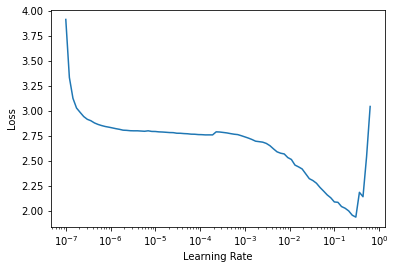

In [185]:
learn.lr_find()

In [193]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_128'),
                                       ShowGraphCallback()])

epoch,train_loss,valid_loss,f1_score,time
0,0.463998,0.624359,0.760527,03:50
1,0.460408,0.635508,0.738585,04:22
2,0.450636,0.646396,0.762600,04:37


Better model found at epoch 0 with f1_score value: 0.7605274235442635.


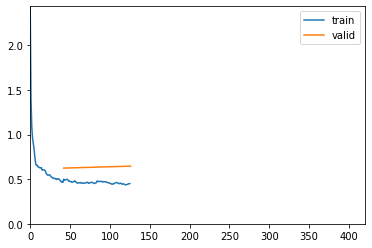

Better model found at epoch 2 with f1_score value: 0.7626003789602782.


In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)

In [ ]:
learn.load("best_sequence_128")
preds, targets = learn.get_preds()

In [ ]:
preds =[np.argmax(x, axis=-1) for sublist in preds for x in sublist]
targets = [x for sublist in targets for x in sublist]
pad_idxs = [i for i,x in enumerate(targets) if x != tensor([12])]
preds = L(preds)[pad_idxs]
targets = L(targets)[pad_idxs]
print(classification_report(targets, preds, target_names=dls.get_labels.cat.vocab, digits=4))

In [ ]:
preds = [x % 6 for x in preds]
targets = [x % 6 for x in targets]
print(classification_report(targets, preds, target_names=[x[2:] for x in dls.get_labels.cat.vocab[:6]], digits=4))

In [ ]:
model = SequenceModel(hidden_dim=256)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, metrics=[MyFScore()])

In [ ]:
learn.summary()

In [ ]:
learn.lr_find()

In [ ]:
learn.add_cbs([SaveModelCallback(monitor='f1_score', fname='best_sequence_256'),
                                       ShowGraphCallback()])

In [ ]:
learn.fit_one_cycle(10, lr_max=1e-2)